# Magic einops

## rearrange

理解 *rearrange* 函数的关键是理解维度的拆分以及合并，以及转置。基于这几个概念，可以将更复杂的变换表达式转分解成一系列简单变换的合成。

### 维度合并 ```"r c -> (r c)"```、拆分 ```"(r c) -> r c"```

看图吧，直观的很，就是二维数组以按行优先存储时，一维表示和二维表示的转换关系。注意所有 *rearrange* 中的操作都是基于这个转换关系的。
$Arr[a1][a2] \cdots [an] = B[a1 * (d_{2} * \cdots * d_{n}) + a2 * (d_{3} * \cdots * d_{n}) + \cdots + an]$

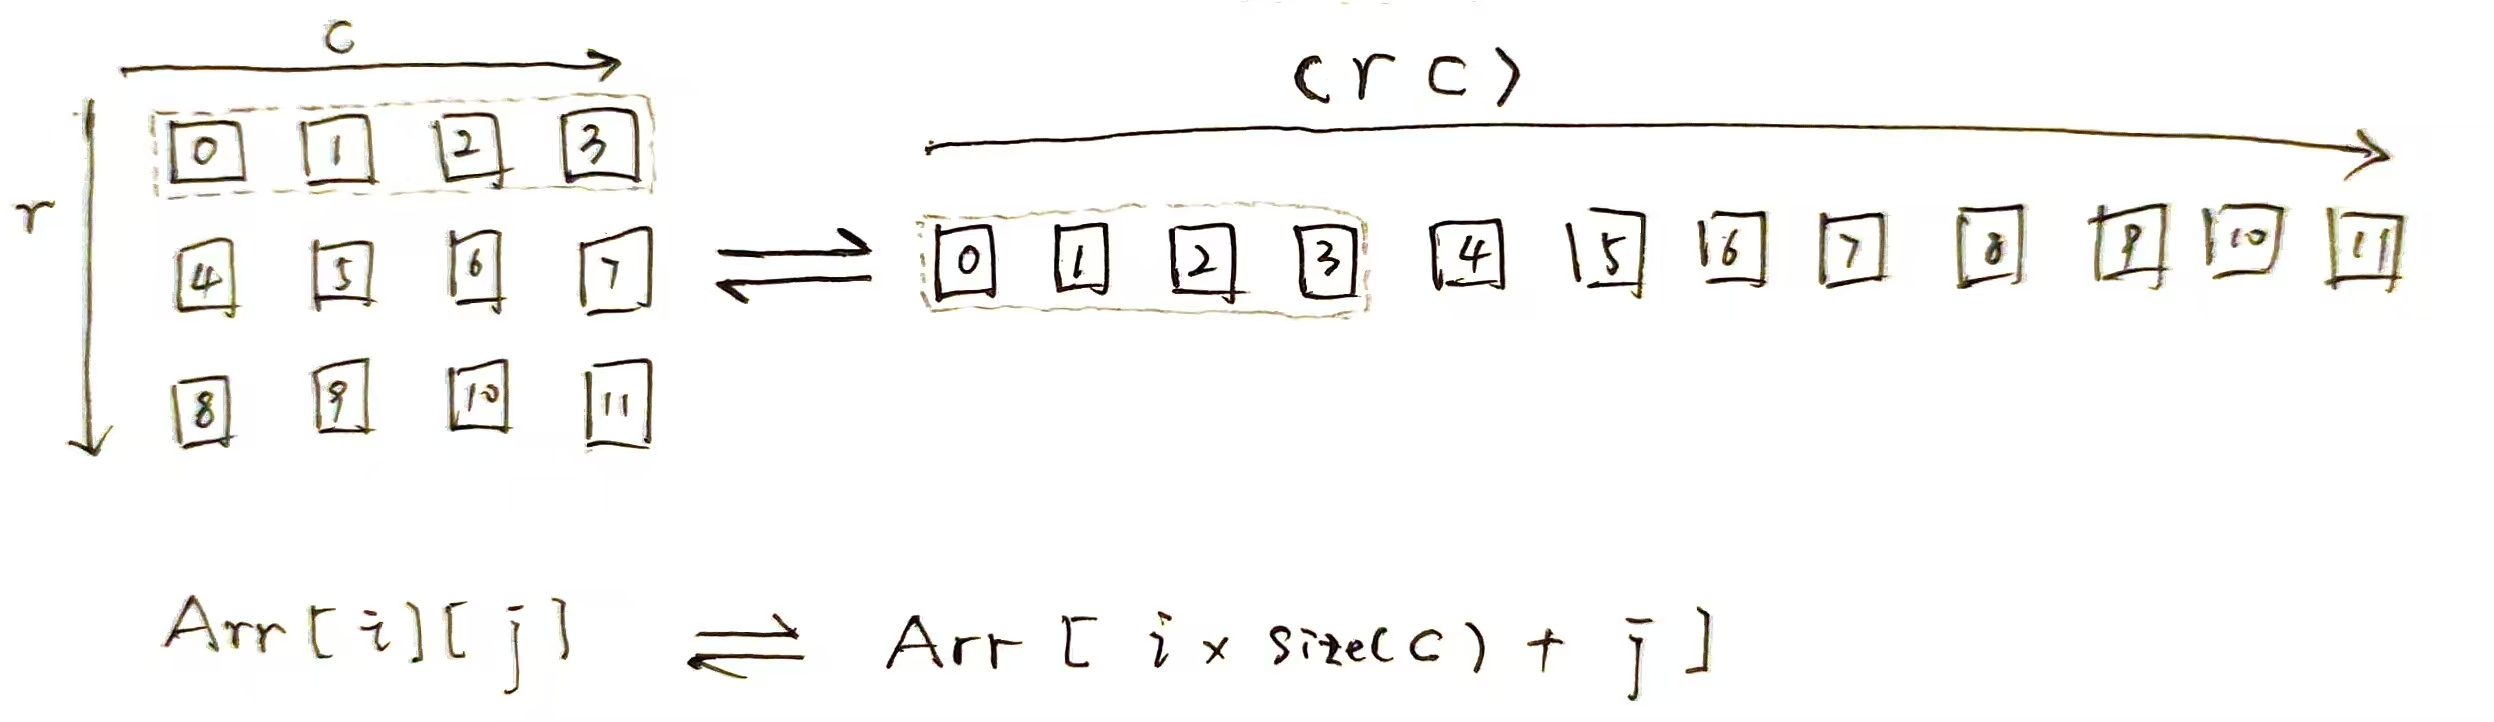




In [12]:
import torch
from einops import rearrange

a = torch.arange(12)
b = rearrange(a, "(r c) -> r c", r=3)
c = rearrange(b, "r c -> (r c)")
print(f"a:\n{a},\nb:\n{b},\nc:\n{c}")

a:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
b:
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]]),
c:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])


### 转置 ```"r c -> c r"```

不用多说，维度翻转，看图：

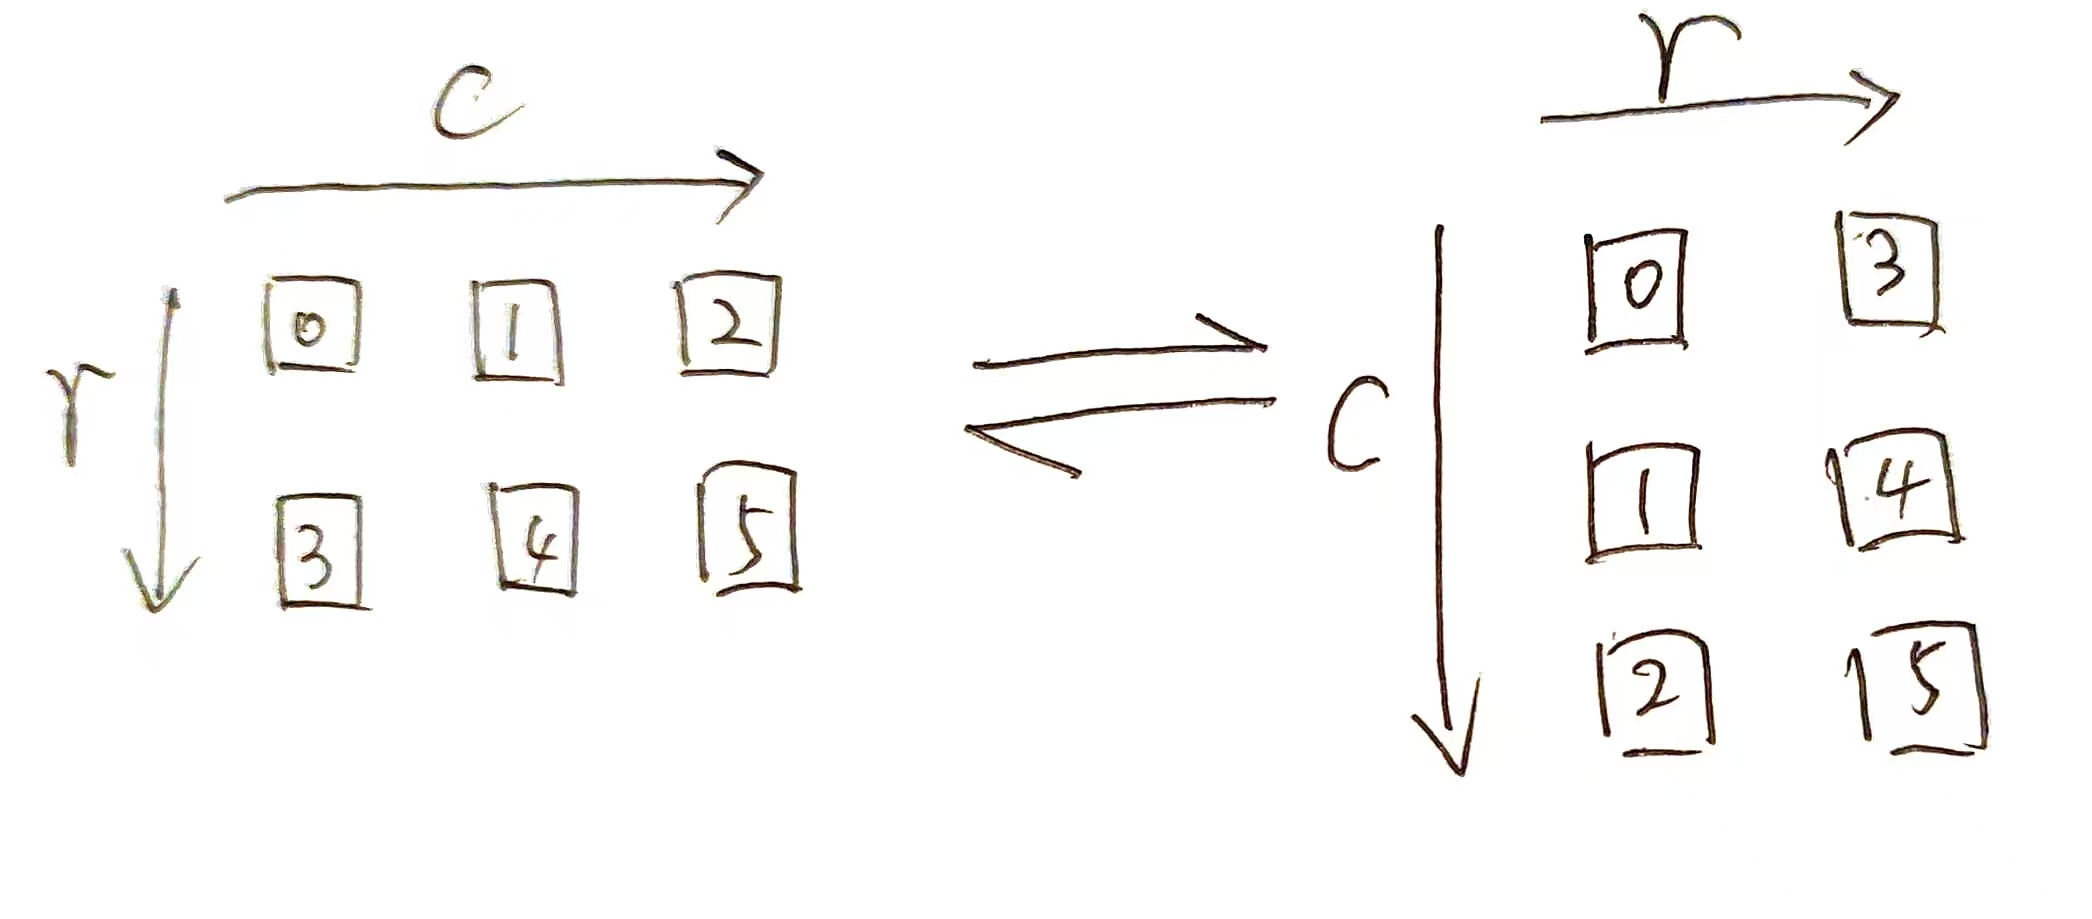


In [14]:
a = torch.arange(6)
b = rearrange(a, "(r c) -> r c", r=2)
c = rearrange(b, "r c -> c r")
d = rearrange(c, "c r -> r c")
print(f"b:\n{b},\nc:\n{c},\nd:\n{d}")

b:
tensor([[0, 1, 2],
        [3, 4, 5]]),
c:
tensor([[0, 3],
        [1, 4],
        [2, 5]]),
d:
tensor([[0, 1, 2],
        [3, 4, 5]])


### 基本语法

*rearrange* 提供了一种非常 elegant 的维度变换的方法，不需要使用 torch 自带的、当维度数量多起来之后让人费解的 *view*, *transpose*。
有时候看到一堆莫名其妙的 *view*、*transpose*, 变换之后维度的意义真的会让人头晕。

任何复杂的表达式都基于3种最基本的语法，维度拆分，合并，转置。

#### ```"(r c) -> r c"```
这个表达式是将一个维度拆分为两个维度，需要在 *rearrange* 最后提供关键字参数 ```r=value``` 或者 ```c=value``` （需保证原始维度大小能够被新维度大小整除，当两个新维度大小都提供时需保证乘积为原始维度大小），来指导具体的拆分行为。
拆分过程理解见前文图示。

#### ```"r c -> (r c)"```
这个表达式是将两个维度合并成一个维度，合并过程理解见前文图示。

#### ```"r c -> c r"```
转置，交换两个维度的位置。

#### 复杂的表达式可以变换成简单表达式的复合过程
举个例子：```"c (th h1) (tw w1) -> (th tw) c h1 w1"```
可以看作是一下系列的复合：

```"c (th h1) (tw w1) -> c th h1 (tw w1)"```:将图片按照高为 h1 的小尺寸划分成 th 个

```"c th h1 (tw w1) -> c th h1 tw w1"```：将图片按照宽为 w1 的小尺寸划分为 tw 个

```"c th h1 tw w1 -> th tw c h1 w1"```：转置维度顺序

```"th tw c h1 w1 -> (th tw) c h1 w1"```：合并新维度，将拆分出的小尺寸图片堆叠起来，并且按照特定顺序堆叠


In [31]:
a = torch.arange(2 * 4 * 6)
img = rearrange(a, "(c h w) -> c h w", h=4, w=6)
split_img = rearrange(img, "c (th h1) (tw w1) -> (th tw) c h1 w1", h1=2, w1=3)
print(f"img:\n{img}\nsplit_img:\n{split_img}")

img:
tensor([[[ 0,  1,  2,  3,  4,  5],
         [ 6,  7,  8,  9, 10, 11],
         [12, 13, 14, 15, 16, 17],
         [18, 19, 20, 21, 22, 23]],

        [[24, 25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34, 35],
         [36, 37, 38, 39, 40, 41],
         [42, 43, 44, 45, 46, 47]]])
split_img:
tensor([[[[ 0,  1,  2],
          [ 6,  7,  8]],

         [[24, 25, 26],
          [30, 31, 32]]],


        [[[ 3,  4,  5],
          [ 9, 10, 11]],

         [[27, 28, 29],
          [33, 34, 35]]],


        [[[12, 13, 14],
          [18, 19, 20]],

         [[36, 37, 38],
          [42, 43, 44]]],


        [[[15, 16, 17],
          [21, 22, 23]],

         [[39, 40, 41],
          [45, 46, 47]]]])


# repeat

*repeat* 的所有变化都是基于：新增维度重复 ```"r -> r c"``` 或者 ```"r -> c r"```
非常好理解，新增一个维度，然后复制原始所有维度（上面是一维，实际上更多维度也是一样的，新维度的其他位置都是通过复制其他维度得到的）

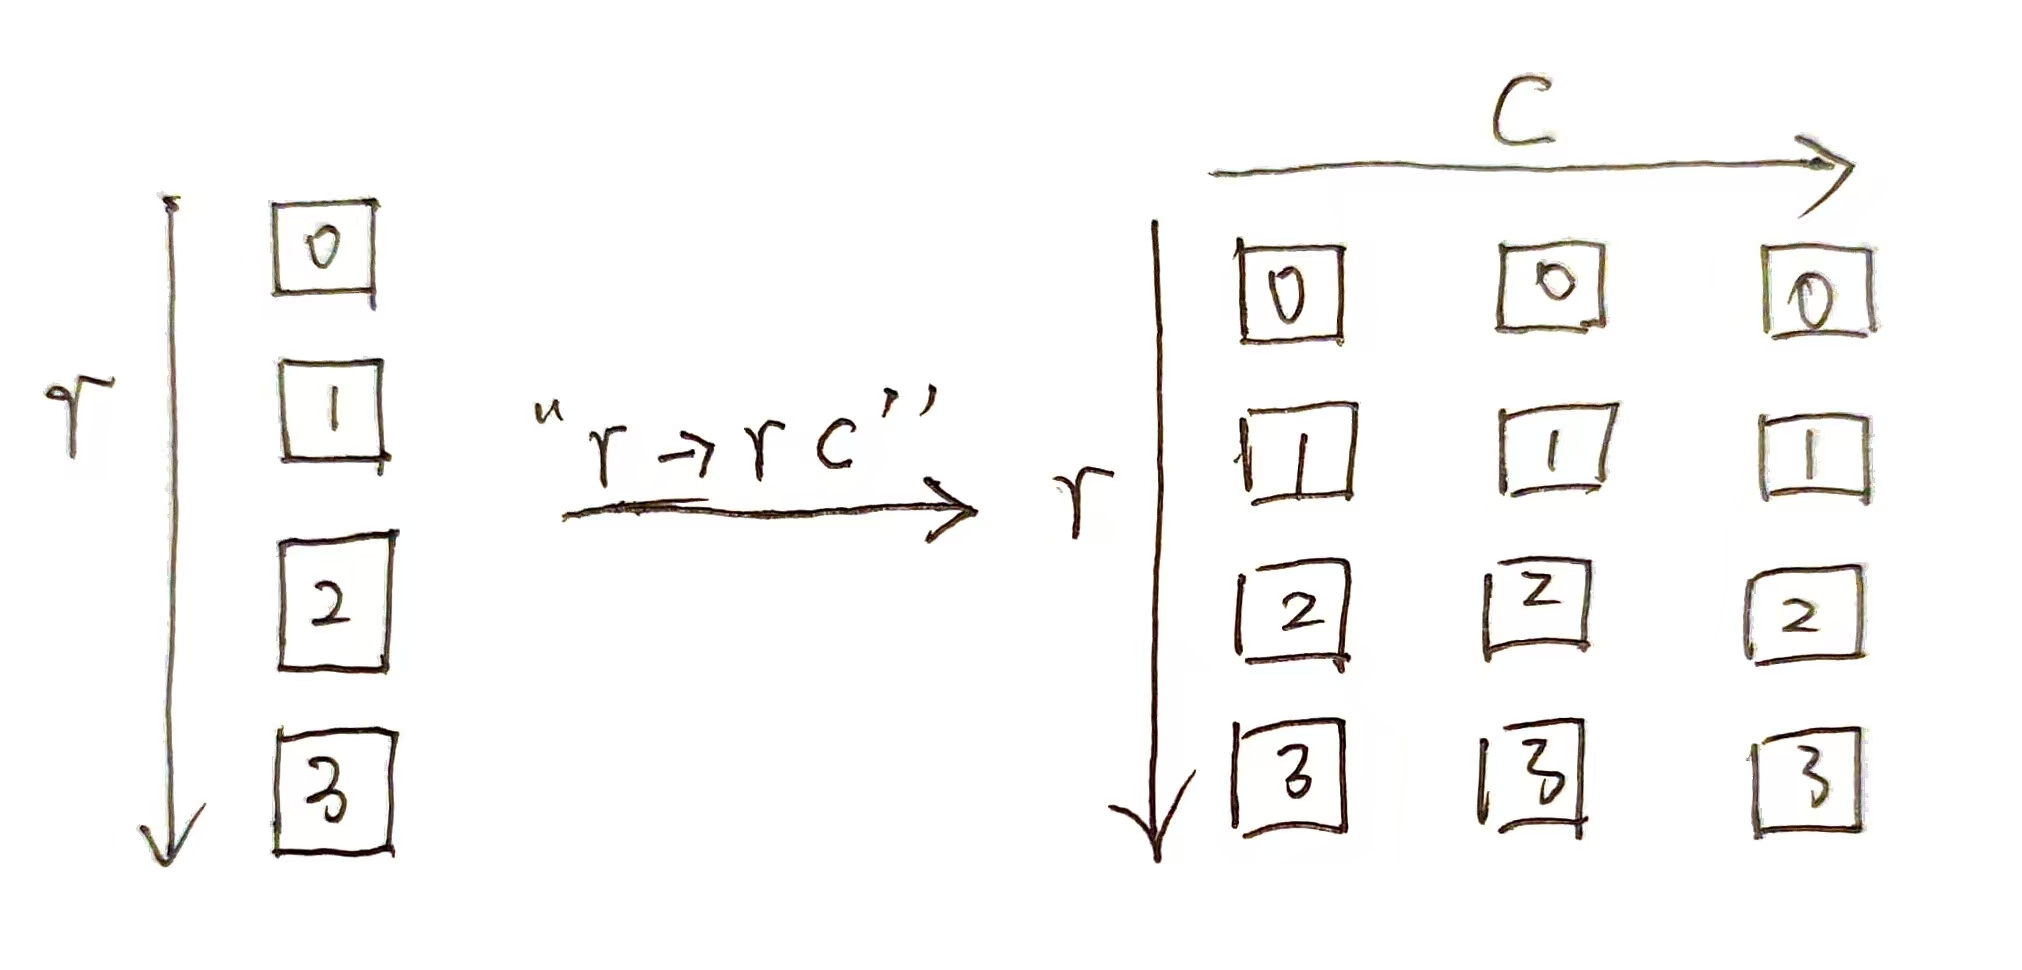


|

In [38]:
from einops import repeat

a = torch.arange(4)
b = repeat(a, "r -> r c", c=3)
c = repeat(a, "r -> c r", c=3)
print(f"a:\n{a}\nb:\n{b}\nc:\n{c}")

a:
tensor([0, 1, 2, 3])
b:
tensor([[0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])
c:
tensor([[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]])


### *repeat* 原始维度重复

使用 *repeat* 对原始维度进行重复无非是在扩增维度重复的基础上加入了 *rearrange* 的维度合并。

```"r -> (r c)"``` 可以理解为：先 ```"r -> r c"```, 再 ```"r c -> (r c)"```。

```"r -> (c r)"``` 可以理解为：先 ```"r -> r c"```, 再 ```"r c -> c r"```,再 ```"c r -> (c r)"```;
或者 ```"r -> c r"```,再 ```"c r -> (c r)"```。

In [39]:
# 例子1：图片 ```"h w -> (th h) (tw w)"```，在高和宽分别扩充 th 和 tw 倍。
a = torch.arange(2 * 3)
img = rearrange(a, "(h w) -> h w", h=2)
repeated_img = repeat(img, "h w -> (th h) (tw w)", th=2, tw=3)
print(f"img:\n{img}\nrepeated_img:\n{repeated_img}")

img:
tensor([[0, 1, 2],
        [3, 4, 5]])
repeated_img:
tensor([[0, 1, 2, 0, 1, 2, 0, 1, 2],
        [3, 4, 5, 3, 4, 5, 3, 4, 5],
        [0, 1, 2, 0, 1, 2, 0, 1, 2],
        [3, 4, 5, 3, 4, 5, 3, 4, 5]])


In [40]:
# 例子2：图片 ```"h w -> (h th) (w tw)"```，图片每个像素填充至 th, tw 倍。
repeated_img = repeat(img, "h w -> (h th) (w tw)", th=2, tw=3)
print(f"img:\n{img}\nrepeated_img:\n{repeated_img}")

img:
tensor([[0, 1, 2],
        [3, 4, 5]])
repeated_img:
tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
        [0, 0, 0, 1, 1, 1, 2, 2, 2],
        [3, 3, 3, 4, 4, 4, 5, 5, 5],
        [3, 3, 3, 4, 4, 4, 5, 5, 5]])


# *reduce*

鸡肋，不用也罢，用 torch 自带的 *reduce* 类型的函数易读性和可维护性都更好